In [25]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tf
import seaborn as sns
import subprocess
from scipy import stats

In [26]:
res = 720
dist = '4_5m'
file_name = '21h7'
bags_dir = '/home/uware/rosbags/dynamic/linear/'
vid_dir = '/home/uware/Downloads/test_vids/dynamic/linear/'
bag = rosbag.Bag(bags_dir + dist + '/'+ str(res) + '/'+ file_name + '.bag')
vid_file = vid_dir + dist + '/'+ str(res) + '/'+ file_name + '.mp4'

# create variables
target = 'is_detected'

# target is to be detected at 0.5m/s ( walking speed is about 1.4m/s )
print(dist + '_'+ file_name + '_'+ str(res))

4_5m_21h7_720


In [27]:
# video length will be used for calculating avr speed
def get_length(filename):
    result = subprocess.run(["ffprobe", "-v", "error", "-show_entries",
                             "format=duration", "-of",
                             "default=noprint_wrappers=1:nokey=1", filename],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT)
    return float(result.stdout)

In [28]:
topic = '/tag_detections'

rows = []
false_positives = []

for topic, msg, t in bag.read_messages(topics=topic):
    time = t.to_sec()
    
    # we only care if there is or there isn't a detection in message published and consider there is only one tag in the frame
    is_detected = len(msg.detections)

    # detection positions are only for information, it is not being used for anything
    if is_detected==1:
        position = msg.detections[0].pose.pose.pose.position
        # add to datapoints if its within measure distance, meaning avoid fp's
        if 4 < position.z < 5:
            x,y,z = position.x, position.y, position.z
            row={'time': time, target: is_detected, 'x': x, 'y': y, 'z': z}
        else:
            false_positives.append(msg.detections[0])
    elif is_detected>1: 
        for detection in msg.detections:
            position = detection.pose.pose.pose.position
            # add to datapoints if its within measure distance, meaning avoid fp's
            if 4 < position.z < 5:
                x,y,z = position.x, position.y, position.z
                row={'time': time, target: 1, 'x': x, 'y': y, 'z': z}
            else:
                false_positives.append(detection)
    elif is_detected==0:
        row={'time': time, target: is_detected, 'x': None, 'y': None, 'z': None}

    rows.append(row)

df = pd.DataFrame.from_records(rows)
print(len(false_positives))

3


In [29]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df.groupby(target)[['x','y']].describe()

x                                                             \
             count      mean      std       min       25%       50%       75%   
is_detected                                                                     
0              0.0       NaN      NaN       NaN       NaN       NaN       NaN   
1            323.0  0.310576  1.94171 -2.832094 -1.457458  0.198183  2.102499   

                           y                                          \
                  max  count      mean       std       min       25%   
is_detected                                                            
0                 NaN    0.0       NaN       NaN       NaN       NaN   
1            3.575706  323.0 -0.011593  0.072831 -0.146113 -0.078504   

                                           
                  50%       75%       max  
is_detected                                
0                 NaN       NaN       NaN  
1           -0.015824  0.053746  0.114461

In [30]:
# show all
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)


,is_detected,x,y,z,relative_time
0,1,-2.620834,-0.121178,4.744471,0.000000
1,1,-2.357353,-0.111516,4.724156,0.464139
2,1,-2.118689,-0.103721,4.697956,0.952046
3,1,-1.892825,-0.094480,4.675930,1.348296
4,1,-1.743241,-0.087944,4.694255,1.727705
5,1,-1.600766,-0.081062,4.669230,2.167992
6,1,-1.444220,-0.078090,4.625831,2.646874
7,1,-1.223275,-0.069616,4.540810,3.232267
8,1,-1.015918,-0.062006,4.555604,3.683412
9,1,-0.797950,-0.054391,4.533216,4.151176


In [31]:
# ratio of detected to not
ratios = df.is_detected.value_counts(normalize=True)*100
ratios

1    98.776758
0     1.223242
Name: is_detected, dtype: float64

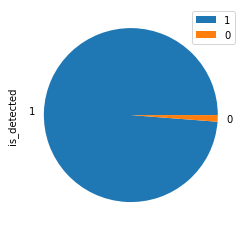

In [32]:
ratios.plot.pie()
plt.legend()

In [33]:
vid_length = get_length(vid_file)
vid_length

12.967

In [34]:
# distance moved
distance = df.x.max() - df.x.min()
distance

6.407799968757913

In [35]:
# velocity in m/s
distance/vid_length

0.49416210139260525

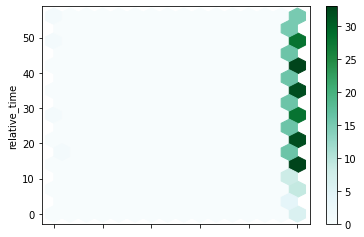

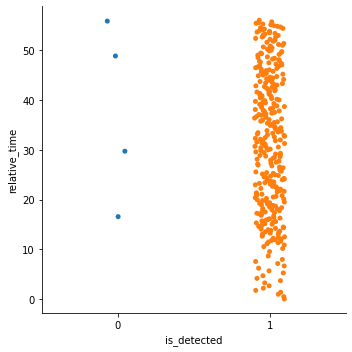

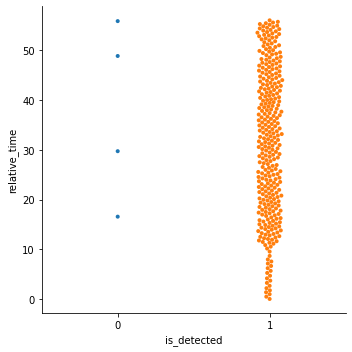

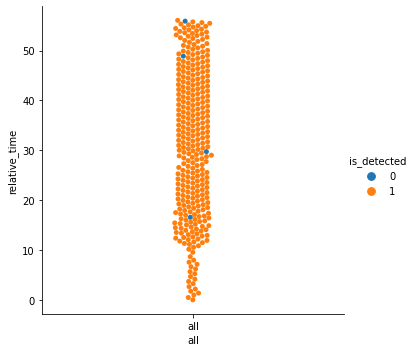

In [36]:
df.plot.hexbin(x=target, y="relative_time", gridsize=15)
sns.catplot(x=target, y='relative_time', data=df)
sns.catplot(x=target, y='relative_time', data=df, kind="swarm", s=4) # s=size of markers causes warnings when >4

# creating a dummy column for plotting both classes together
df.loc[:,'all'] = 'all'
sns.catplot(x='all', y='relative_time', data=df, hue=target, kind="swarm")